In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## **Creating the Maze Environment**

In [2]:
class Maze:
    def __init__(self, layout, start_position, goal_position):
        # Initialize Maze object with the provided maze, start_position, and goal position
        self.layout = layout
        self.maze_height = layout.shape[0] # Get the height of the maze (number of rows)
        self.maze_width = layout.shape[1]  # Get the width of the maze (number of columns)
        self.start_position = start_position    # Set the start position in the maze as a tuple (x, y)
        self.goal_position = goal_position      # Set the goal position in the maze as a tuple (x, y)

    def show(self):
        # Visualize the maze using Matplotlib
        plt.figure(figsize=(5,5))

        # Display the maze as an image in grayscale ('gray' colormap)
        plt.imshow(self.layout, cmap='gray')

        # Add start and goal positions as 'S' and 'G'
        plt.text(self.start_position[0], self.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[0], self.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)

        # Remove ticks and labels from the axes
        plt.xticks([]), plt.yticks([])

        # Show the plot
        plt.show()

## **Load the generated maze**

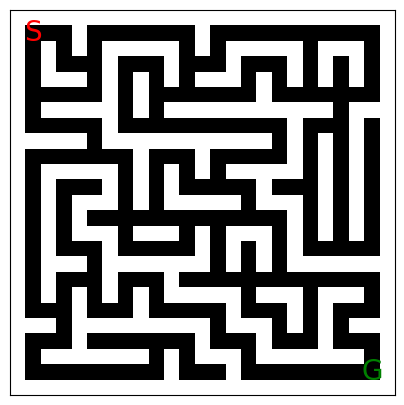

In [3]:
height = 25
width = 25

filename = f'mazes/{height}x{width}_layout.npy'
layout = np.load(filename)

start_position = (1,1)
goal_position = (23, 23)

# Make sure the start and end point is not in a wall
if layout[start_position] == 1:
    raise ValueError("Make sure the start position is not in the wall")
elif layout[goal_position] == 1:
    raise ValueError("Make sure the goal position is not in the wall")

maze = Maze(layout, start_position=start_position, goal_position=goal_position)
maze.show()

## **Implementing the agent**

In [4]:
actions = [(-1, 0), # Up: Moving one step up, reducing the row index by 1
          (1, 0),   # Down: Moving on step down, increasing the row index by 1
          (0, -1),  # Left: Moving one step to the left, reducing the column index by 1
          (0, 1)]   # Right: Moving one step to the right, increasing the column index by 1

class QLearningAgent:
    def __init__(self, maze, learning_rate, discount_factor, exploration_start, exploration_end, num_episodes):
        # Initialize the Q-learning agent with a Q-table containing all zeros
        # where the rows represent states, columns represent actions, and the third dimension is for each action (Up, Down, Left, Right)
        self.q_table = np.zeros((maze.maze_height, maze.maze_width, 4)) # 4 actions: Up, Down, Left, Right
        self.learning_rate = learning_rate          # Learning rate controls how much the agent updates its Q-values after each action
        self.discount_factor = discount_factor      # Discount factor determines the importance of future rewards in the agent's decisions
        self.exploration_start = exploration_start  # Exploration rate determines the likelihood of the agent taking a random action
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes

    def get_exploration_rate(self, current_episode):
        # Calculate the current exploration rate using the given formula
        exploration_rate = self.exploration_start * (self.exploration_end / self.exploration_start) ** (current_episode / self.num_episodes)
        return exploration_rate

    def get_action(self, state, current_episode): # State is tuple representing where agent is in maze (x, y)
        exploration_rate = self.get_exploration_rate(current_episode)
        # Select an action for the given state either randomly (exploration) or using the Q-table (exploitation)
        if np.random.rand() < exploration_rate:
            return np.random.randint(4) # Choose a random action (index 0 to 3, representing Up, Down, Left, Right)
        else:
            return np.argmax(self.q_table[state]) # Choose the action with the highest Q-value for the given state

    def update_q_table(self, state, action, next_state, reward):
        # Find the best next action by selecting the action that maximizes the Q-value for the next state
        best_next_action = np.argmax(self.q_table[next_state])

        # Get the current Q-value for the current state and action
        current_q_value = self.q_table[state][action]

        # Q-value update using Q-learning formula
        new_q_value = current_q_value + self.learning_rate * (reward + self.discount_factor * self.q_table[next_state][best_next_action] - current_q_value)

        # Update the Q-table with the new Q-value for the current state and action
        self.q_table[state][action] = new_q_value

## **Defining the Reward System**

In [5]:
goal_reward = 100
wall_penalty = -10
step_penalty = -1

## **Implementing agent helper functions**

In [6]:
def finish_episode(agent: QLearningAgent, maze: Maze, current_episode, train):
    # Initialize the agent's current state to the maze's start position
    current_state = maze.start_position
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [current_state]

    # Start the timer
    start_time = time.time()

    # Continue until the episode is done
    while not is_done:
        # Check if the time limit has been exceeded when not training
        if not train and (time.time() - start_time) > 5:
            print("Time limit exceeded, agent did not find the goal")
            return episode_reward, episode_step, path

        # Get the agent's action for the current state using its Q-table
        action = agent.get_action(current_state, current_episode)

        # Compute the next state based on the chosen action
        next_state = (current_state[0] + actions[action][0], current_state[1] + actions[action][1])

        # Check if the next state is out of bounds or hitting a wall
        if next_state[0] < 0 or next_state[0] >= maze.maze_height or next_state[1] < 0 or next_state[1] >= maze.maze_width or maze.layout[next_state[1]][next_state[0]] == 1:
            reward = wall_penalty
            next_state = current_state
        # Check if the agent reached the goal:
        elif next_state == (maze.goal_position):
            path.append(current_state)
            reward = goal_reward
            is_done = True
        # The agent takes a step but hasn't reached the goal yet
        else:
            path.append(current_state)
            reward = step_penalty

        # Update the cumulative reward and step count for the episode
        episode_reward += reward
        episode_step += 1

        # Update the agent's Q-table if training is enabled
        if train == True:
            agent.update_q_table(current_state, action, next_state, reward)

        # Move to the next state for the next iteration
        current_state = next_state

    return episode_reward, episode_step, path

In [7]:
def test_agent(agent, maze: Maze, num_episodes=10000):
    # Simulate the agent's behavior in the maze for the specified number of episodes
    episode_reward, episode_step, path = finish_episode(agent, maze, num_episodes, train=False)

    # Print the learned path of the agent
    if len(path)<maze.maze_height*5: # Arbritrarily chosen path lenght
      print("Learned Path:")
      for row, col in path:
          print(f"({row}, {col})-> ", end='')
      print("Goal!")

    print("Number of steps:", episode_step)
    print("Total reward:", episode_reward)

    # Clear the existing plot if any
    if plt.gcf().get_axes():
        plt.cla()

    # Visualize the maze using matplotlib
    plt.figure(figsize=(5,5))
    plt.imshow(maze.layout, cmap='gray')

    # Mark the start position (red 'S') and goal position (green 'G') in the maze
    plt.text(maze.start_position[0], maze.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
    plt.text(maze.goal_position[0], maze.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)

    #Mark the agent's path with blue '#' symbols
    # Create a set to keep track of positions where '#' has already been drawn
    drawn_positions = set()

    for position in path:
        # Check if the position is already in the set
        if tuple(position) not in drawn_positions:
            # Draw the text and add the position to the set
            plt.text(position[0]-1, position[1], "#", va='center', color='blue', fontsize=15)
            drawn_positions.add(tuple(position))


    # Remove axis ticks and grid lines for a cleaner visualization
    plt.xticks([]), plt.yticks([])
    plt.grid(color='black', linewidth=2)
    plt.show()

    return

In [8]:
def plot_training(avg_rewards, avg_episodes, num_runs):
    # Plotting the averaged data after all runs are completed
    plt.figure(figsize=(10, 5))

    # Plot average reward per episode
    plt.subplot(1, 2, 1)
    plt.plot(avg_rewards, label='Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.ylim(-10000, 200)
    plt.title(f'Average Reward per Episode (Averaged over {num_runs} runs)')

    # Plot average steps per episode
    plt.subplot(1, 2, 2)
    plt.plot(avg_episodes, label='Average Steps')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Episode')
    plt.ylabel('Steps Taken')
    plt.ylim(-50, 2000)
    plt.title(f'Average Steps per Episode (Averaged over {num_runs} runs)')

    plt.tight_layout()
    plt.show()

## **Setting Up the Reinforcement Learning Loop**

In [9]:
def train_agent(agent_factory, maze, num_episodes, num_runs):
    # To store all runs data: each entry in these lists will be an array of length `num_episodes`.
    all_runs_rewards = []
    all_runs_steps = []

    # Perform multiple runs
    for run_idx in range(num_runs):
        # Create a new agent for this run
        agent = agent_factory(num_episodes)

        episode_rewards = []
        episode_steps = []

        # Run the training loop for the specified number of episodes
        for episode in tqdm(range(num_episodes), desc=f"Training Progress (Run {run_idx+1}/{num_runs})"):
            episode_reward, episode_step, path = finish_episode(agent, maze, episode, train=True)
            episode_rewards.append(episode_reward)
            episode_steps.append(episode_step)

        # Store the results for this run
        all_runs_rewards.append(episode_rewards)
        all_runs_steps.append(episode_steps)

    # Convert lists of lists into arrays for easier averaging
    all_runs_rewards = np.array(all_runs_rewards)  # Shape: (num_runs, num_episodes)
    all_runs_steps = np.array(all_runs_steps)      # Shape: (num_runs, num_episodes)

    # Compute average over runs for each episode
    avg_rewards_per_episode = np.mean(all_runs_rewards, axis=0)
    avg_steps_per_episode = np.mean(all_runs_steps, axis=0)

    # Compute overall averages
    final_avg_reward = np.mean(avg_rewards_per_episode)
    final_avg_steps = np.mean(avg_steps_per_episode)

    print(f"\nAveraged over {num_runs} runs:")
    print(f"The average reward per run is: {final_avg_reward}")
    print(f"The average steps per run is: {final_avg_steps}")
    
    return agent, avg_rewards_per_episode, avg_steps_per_episode


## **Creating, training and testing the agent**

In [10]:
def agent_factory(num_episodes):
    return QLearningAgent(
            maze,
            learning_rate = 0.2,
            discount_factor = 0.9,
            exploration_start = 1,
            exploration_end = 0.2,
            num_episodes = num_episodes
        )

Training Progress (Run 250/250): 100%|██████████| 100/100 [00:00<00:00, 204.95it/s]



Averaged over 250 runs:
The average reward per run is: -5057.922480000001
The average steps per run is: 1174.83452


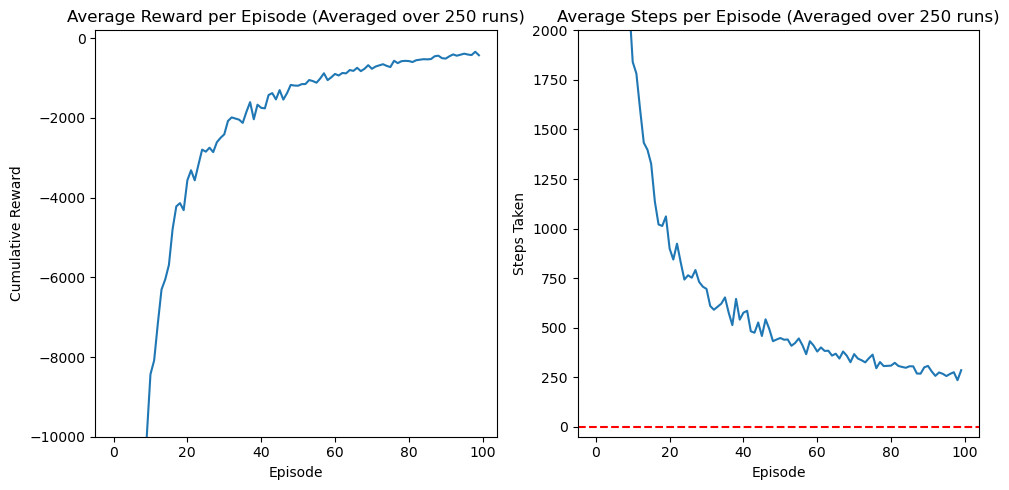

Time limit exceeded, agent did not find the goal
Number of steps: 2892399
Total reward: -2892399


<Figure size 640x480 with 0 Axes>

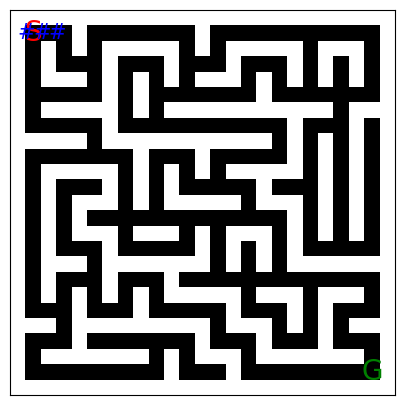

In [11]:
num_episodes = 100
num_runs = 250
last_agent, avg_rewards, avg_steps = train_agent(agent_factory, maze, num_episodes, num_runs)

# Plot data from training
plot_training(avg_rewards, avg_steps, num_runs)

# Testing the agent after training
test_agent(last_agent, maze)

In [12]:
# Save training data for comparison
saved_array = [avg_rewards, avg_steps]

filename = 'model_3_training_data'
np.save('training_data/' + filename, saved_array)